<h1>Spectral characterisation of sensors</h1>

Analysis of the produced sensors spectral characteristic is a part of the quality control. Collected data of spectral measurements represents characteristic of correct sensors and it will be a reference standard.

<h2>1. Import needed packages and libraries</h2>

In [4]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import re
import pickle


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error 

import ind4_f

<h2>2. Import Data and prepare standard datasets</h2>

Import data from readouts and prepare datasets for air, water and izopropanol separately. amplitude readouts from each sensor will be appended in separated columns.

In [62]:
def std_spectrum(environment):
    
    # create dataframe from environment readouts
    
    data_folder = './Dataset/**/*'
    
    path = sorted(glob.glob(data_folder + f'*_{environment}.txt'))
    
    files = []

    for filename in path:
        df = pd.read_csv(filename, header=None, index_col=None)
        df.columns = ['Wavelenght [nm]', 'Amplitude']
        df['Wavelenght [nm]'] = df['Wavelenght [nm]'] * 1000000000
        files.append(df)

    df_conc = pd.concat(files, axis=0, ignore_index=True)
    
    # create dataset with mean amplitude and standard deviations
    
    df2 = df_conc.groupby(['Wavelenght [nm]'], as_index=False).agg({'Amplitude': 'std'})
    df2.rename({'Amplitude' : 'Amplitude_std'}, axis=1, inplace=True)
    df3 = df_conc.groupby(['Wavelenght [nm]'], as_index=False).agg({'Amplitude': 'mean'})
    df3.rename({'Amplitude' : 'Amplitude_mean'}, axis=1, inplace=True)
    df_st = df3.merge(df2, on=('Wavelenght [nm]'))
    df_st['Amplitude + STD'] = df_st['Amplitude_mean'] + df_st['Amplitude_std']
    df_st['Amplitude - STD'] = df_st['Amplitude_mean'] - df_st['Amplitude_std']
    df_st
    
    # plot 
    
    fig, ax = plt.subplots(figsize=(8, 4))

    ax.set_xlabel("Wavelenght, nm")
    ax.set_ylabel("P/Pref [dB]")

    ax.plot(df_st['Wavelenght [nm]'], df_st['Amplitude_mean'], color = 'darkgreen', label = 'Mean amplitude')
    ax.plot(df_st['Wavelenght [nm]'], df_st['Amplitude + STD'], color = 'lightgrey', label = 'Mean amplitude + STD')
    ax.plot(df_st['Wavelenght [nm]'], df_st['Amplitude - STD'], color = 'lightgrey', label = 'Mean amplitude - STD')

    ax.legend()

    plt.show()
    
    return df_st



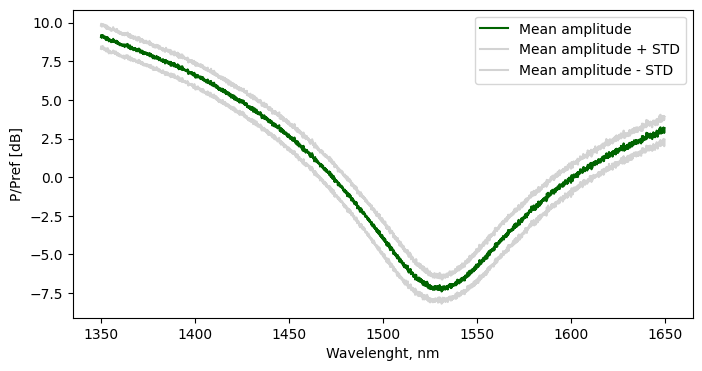

,Wavelenght [nm],Amplitude_mean,Amplitude_std,Amplitude + STD,Amplitude - STD
0,1350.0,9.068962,0.749483,9.818446,8.319479
1,1350.1,9.198875,0.732632,9.931507,8.466243
2,1350.2,9.157650,0.738441,9.896091,8.419209
3,1350.3,9.094025,0.719883,9.813908,8.374142
4,1350.4,9.030250,0.746709,9.776959,8.283541
...,...,...,...,...,...
2996,1649.6,2.912350,0.787693,3.700043,2.124657
2997,1649.7,3.083638,0.725719,3.809357,2.357918
2998,1649.8,2.864612,0.861199,3.725811,2.003414
2999,1649.9,3.124175,0.777935,3.902110,2.346240


In [64]:
air_st = std_spectrum('air')
air_st

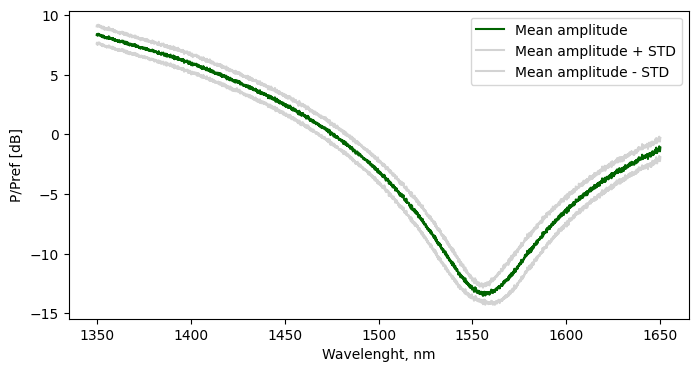

(      Wavelenght [nm]  Amplitude_mean  Amplitude_std  Amplitude + STD  \
 0              1350.0        8.334487       0.721865         9.056353   
 1              1350.1        8.420250       0.731283         9.151533   
 2              1350.2        8.379162       0.736476         9.115639   
 3              1350.3        8.342813       0.736970         9.079783   
 4              1350.4        8.277700       0.777299         9.054999   
 ...               ...             ...            ...              ...   
 2996           1649.6       -1.347085       0.808265        -0.538820   
 2997           1649.7       -1.320859       0.802731        -0.518127   
 2998           1649.8       -1.419681       0.820985        -0.598696   
 2999           1649.9       -1.216814       0.864128        -0.352686   
 3000           1650.0       -1.107074       0.809151        -0.297923   
 
       Amplitude - STD  
 0            7.612622  
 1            7.688967  
 2            7.642686  
 3        

In [44]:
water_st = std_spectrum('water')
water_st

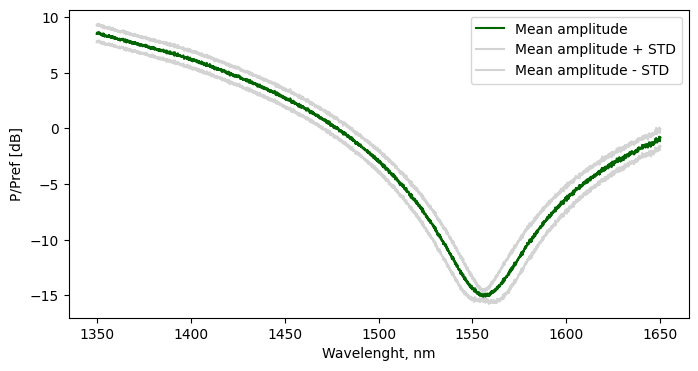

(      Wavelenght [nm]  Amplitude_mean  Amplitude_std  Amplitude + STD  \
 0              1350.0        8.501825       0.753782         9.255607   
 1              1350.1        8.609488       0.746386         9.355874   
 2              1350.2        8.569125       0.717338         9.286463   
 3              1350.3        8.552100       0.729562         9.281662   
 4              1350.4        8.498900       0.746869         9.245769   
 ...               ...             ...            ...              ...   
 2996           1649.6       -1.135434       0.804079        -0.331355   
 2997           1649.7       -1.053608       0.794001        -0.259607   
 2998           1649.8       -1.146326       0.749927        -0.396400   
 2999           1649.9       -0.841168       0.786083        -0.055085   
 3000           1650.0       -0.810443       0.779710        -0.030733   
 
       Amplitude - STD  
 0            7.748043  
 1            7.863101  
 2            7.851787  
 3        

In [45]:
izo_st = std_spectrum('izopropanol')
izo_st

<h2>3. Load Data for testing</h2>

In [83]:
# environment = 'air' -> we will have data to test from the air only; izo and water spectra will be predicted using models

data_folder = './Test_dataset/**/*'
    
path = sorted(glob.glob(data_folder + '*_air.txt'))
    
files = []

for filename in path:
    df = pd.read_csv(filename, header=None, index_col=None)
    df.columns = ['Wavelenght [nm]', 'Amplitude']
    df['Wavelenght [nm]'] = df['Wavelenght [nm]'] * 1000000000
    files.append(df)
    print(f'{filename} was apended')
    
files[0]

./Test_dataset/sesion_09_20/sensor09_air.txt was apended
./Test_dataset/sesion_10_20/sensor10_air.txt was apended


,Wavelenght [nm],Amplitude
0,1350.0,8.6910
1,1350.1,8.7223
2,1350.2,8.7796
3,1350.3,8.6753
4,1350.4,8.6667
...,...,...
2996,1649.6,2.7312
2997,1649.7,2.7287
2998,1649.8,2.5725
2999,1649.9,2.7335


In [91]:
dfs_comp = []

for i in enumerate(files):
    df_comp = files[i].merge(air_st, on=('Wavelenght [nm]'))
    is_in_range = lambda row: row['Amplitude - STD']<=row['Amplitude']<=row['Amplitude + STD']
    df_comp['Is in range'] = df_comp.apply(is_in_range, axis = 1)
    dfs_comp.append(df_comp)

dfs_comp


TypeError: list indices must be integers or slices, not tuple

In [ ]:
df1 = pd.DataFrame({'a':[1,1,2,2], 'b':[1,1,2,2], 'c':[2,-1,4,5]})
myfun = lambda row: row['Amplitude - STD']<=row['Amplitude']<=row['Amplitude - STD']
df1['Is In range'] = df1.apply(myfun, axis=1)
display(df1)